In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

In [2]:
# os.getcwd() # 현재작업 폴더 반환
# os.chdir(path)  # 작업폴더 변경. path를 설정할 때 유용.

In [10]:
path = os.getcwd()
os.chdir(path)

In [11]:
# 데이터 불러오기
df = pd.read_csv('0.Model\data\movie.csv')

original_df = df.copy()

df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['genres'] = df['genre'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors_s'] = df['actors'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,serial,title_kor,release,just_rating,imdb_rating,runtime,synopsis,director,actors,genre,poster_link,netflix,disney,wavve,watcha,directors,genres,actors_s
0,261279536,효자,2022,55%,55%,1시간57분,엄마가 돌아가시고 얼마 지나지 않아 닥친 태풍 소식에 5명의 형제들은 함께 산소를 ...,LeeHoon-guk,"KimRoi-ha,LeeCheol-min,JungKyung-ho,ParkHyo-jo...","공포,코미디",https://images.justwatch.com/poster/261279536/...,0,0,1,0,[LeeHoon-guk],"[공포, 코미디]","[KimRoi-ha, LeeCheol-min, JungKyung-ho, ParkHy..."
1,259066109,황무지의 괴물,2022,54%,4.6,1시간31분,19세기 외딴 황무지에 세상과 단절된 채 살아가는 가족이 있다. 이 집의 어린 아들...,NaN,"InmaCuesta,AsierFlores,RobertoÁlamo,AlejandraH...","공포,스릴러,드라마",https://images.justwatch.com/poster/259066109/...,1,0,0,0,[],"[공포, 스릴러, 드라마]","[InmaCuesta, AsierFlores, RobertoÁlamo, Alejan..."
2,261668749,홈 팀,2022,74%,6,1시간35분,자격 정지 처분을 받은 NFL 감독 숀 페이턴. 아들이 선수로 뛰는 형편없는 유소년...,"CharlesKinnane,DanielKinnane","KevinJames,TaylorLautner,RobSchneider,JackieSa...","코미디,스포츠",https://images.justwatch.com/poster/261668749/...,1,0,0,0,"[CharlesKinnane, DanielKinnane]","[코미디, 스포츠]","[KevinJames, TaylorLautner, RobSchneider, Jack..."
3,259326899,해적: 도깨비 깃발,2022,74%,6.1,2시간6분,자칭 고려 제일검인 의적단 두목 무치와 바다를 평정한 해적선의 주인 해랑. 한 배에...,KimJoung-hoon,"KangHa-neul,HanHyo-joo,LeeKwang-soo,KwonSang-w...","코미디,액션",https://images.justwatch.com/poster/259326899/...,1,0,0,0,[KimJoung-hoon],"[코미디, 액션]","[KangHa-neul, HanHyo-joo, LeeKwang-soo, KwonSa..."
4,258528334,해리 포터 20주년: 리턴 투 호그와트,2022,89%,8,1시간43분,"‘해리포터와 마법사의 돌' 20주년 기념 스페셜. 다니엘 래드클리프, 루퍼트 그린트...","EranCreevy,JoePearlman,CaseyPatterson,GiorgioT...","DanielRadcliffe,RupertGrint,EmmaWatson,BonnieW...","다큐멘터리,가족",https://images.justwatch.com/poster/258528334/...,0,0,1,0,"[EranCreevy, JoePearlman, CaseyPatterson, Gior...","[다큐멘터리, 가족]","[DanielRadcliffe, RupertGrint, EmmaWatson, Bon..."


In [12]:
start_time = time.time()
text_content = df['synopsis']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

In [13]:
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

    
request_transform = vector.transform(df['synopsis'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 
df['cluster'].value_counts().head()

6     14382
8        16
10       12
16        4
32        4
Name: cluster, dtype: int64

In [14]:
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title_kor'],key=rowi['serial'],label="MOVIE",mtype=rowi['genre'],rating=rowi['imdb_rating'])
    for element in rowi['actors_s']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title_kor'], element, label="ACTED_IN")
    for element in rowi['genres']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title_kor'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title_kor'], element, label="DIRECTED")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title_kor'].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title_kor'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title_kor'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time)) 

 iter 0 -- 0.019133806228637695 seconds --
 iter 1000 -- 25.78425121307373 seconds --
 iter 2000 -- 51.59221434593201 seconds --
 iter 3000 -- 75.02739524841309 seconds --
 iter 4000 -- 98.04597759246826 seconds --
 iter 5000 -- 120.97036790847778 seconds --
 iter 6000 -- 144.69743299484253 seconds --
 iter 7000 -- 167.54526376724243 seconds --
 iter 8000 -- 191.2645983695984 seconds --
 iter 9000 -- 217.80998539924622 seconds --
 iter 10000 -- 242.91170144081116 seconds --
 iter 11000 -- 267.5092477798462 seconds --
 iter 12000 -- 294.91213393211365 seconds --
 iter 13000 -- 322.50050139427185 seconds --
 iter 14000 -- 354.62068700790405 seconds --
 finish -- 375.0450830459595 seconds --


In [37]:
import matplotlib.font_manager as fm
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams["figure.figsize"] = (12,10)

In [39]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_family=font_name,font_weight='bold', node_color=colors, font_size=8)
    plt.show()

    # nx.draw_networkx_labels(Gs[i],pos,Gs_label[i],font_family=font_name,font_size=10)

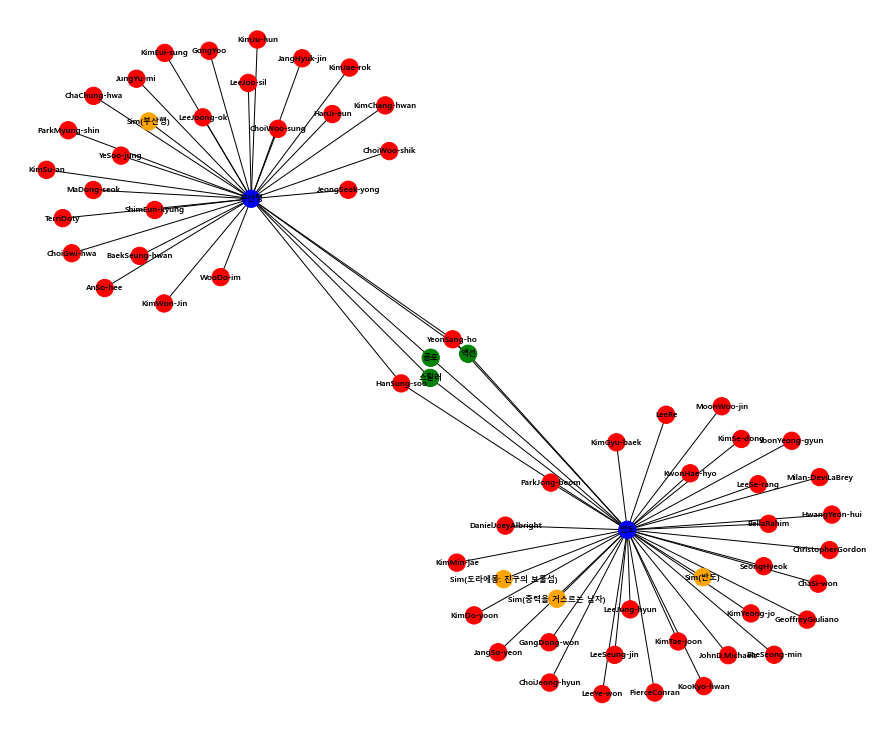

In [40]:
list_in=["반도","부산행"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

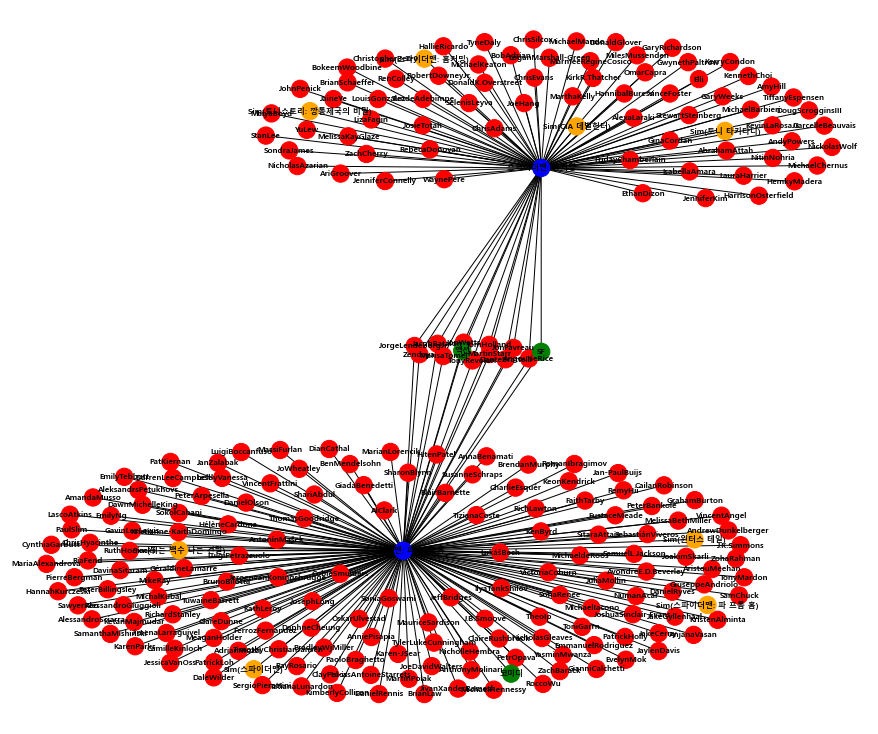

In [41]:
list_in=["스파이더맨: 홈커밍","스파이더맨: 파 프롬 홈"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

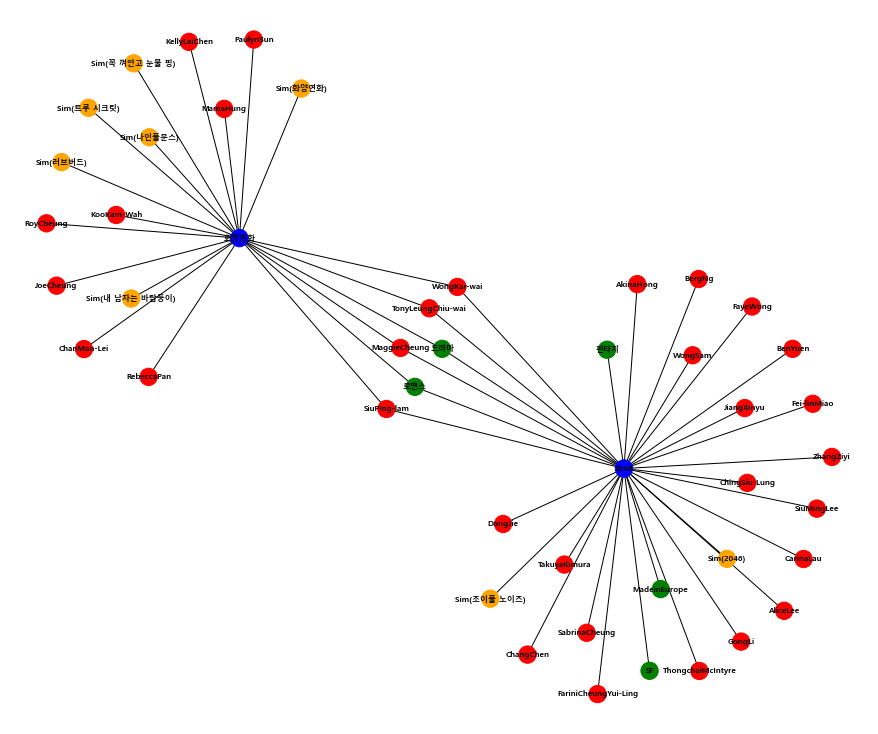

In [45]:
list_in=["2046","화양연화"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

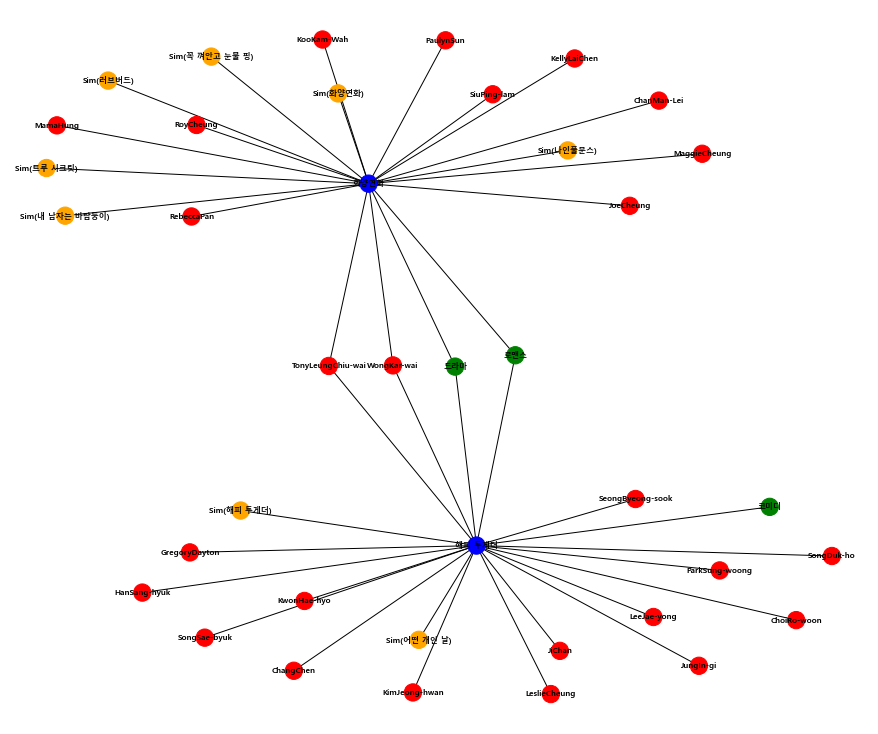

In [42]:
list_in=["해피 투게더","화양연화"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [20]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

In [23]:
result = get_recommendation("스파이더맨: 파 프롬 홈")
print("*"*40+"\n Recommendation for '스파이더맨: 파 프롬 홈'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '스파이더맨: 파 프롬 홈'
****************************************
스파이더맨: 홈커밍        6.104876
분노의 질주: 홉스 & 쇼    5.478773
스파이더맨: 노 웨이 홈     5.135513
아르테미스 파울          4.841783
한 솔로: 스타워즈 스토리    4.722141
dtype: float64


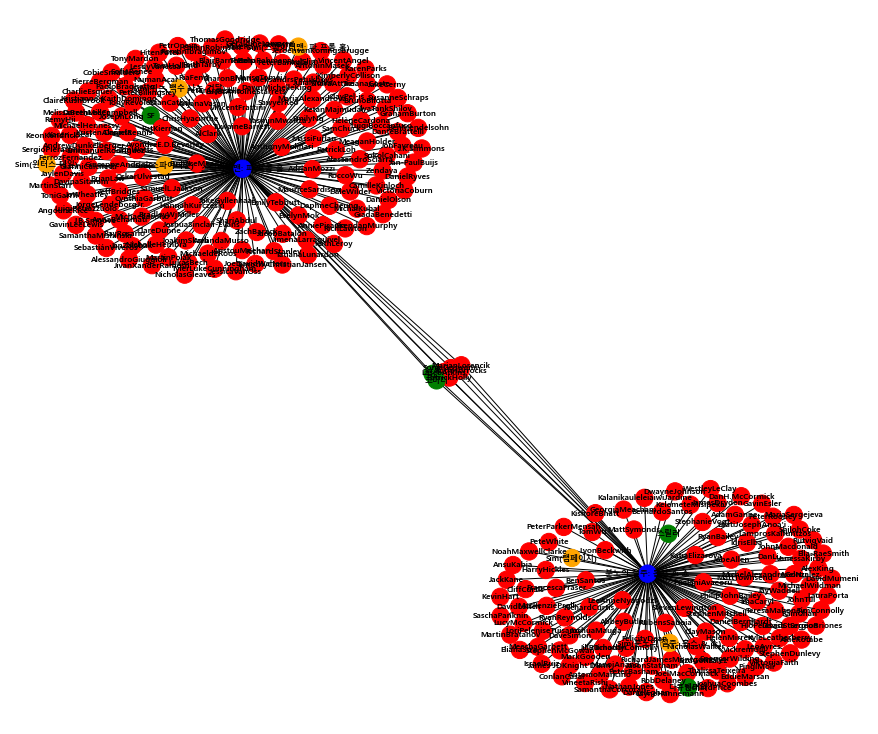

In [47]:
list_in=["스파이더맨: 파 프롬 홈","분노의 질주: 홉스 & 쇼"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

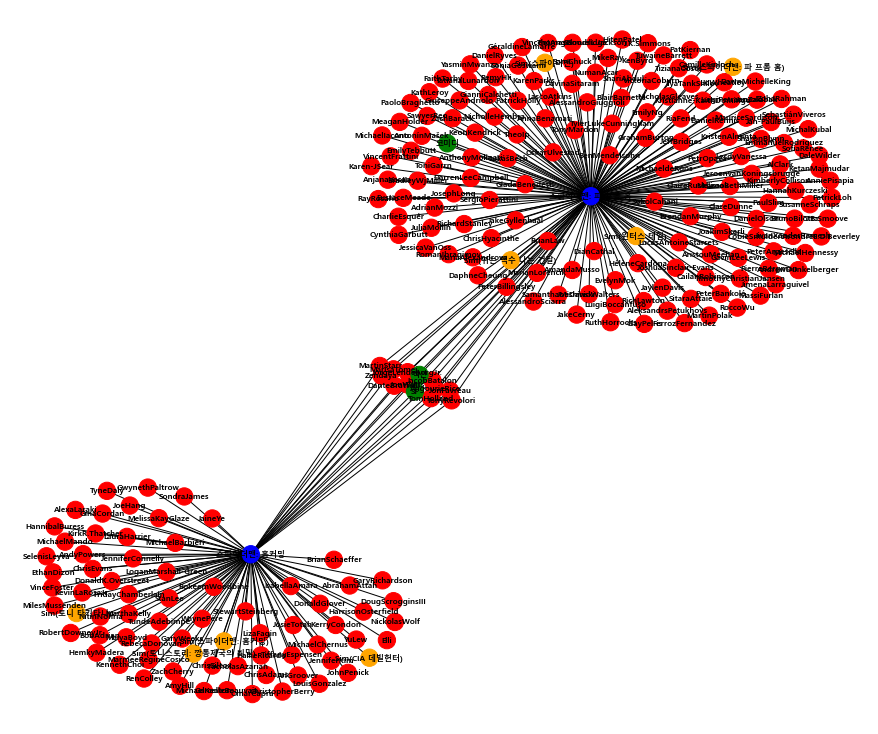

In [48]:
list_in=["스파이더맨: 파 프롬 홈","스파이더맨: 홈커밍"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

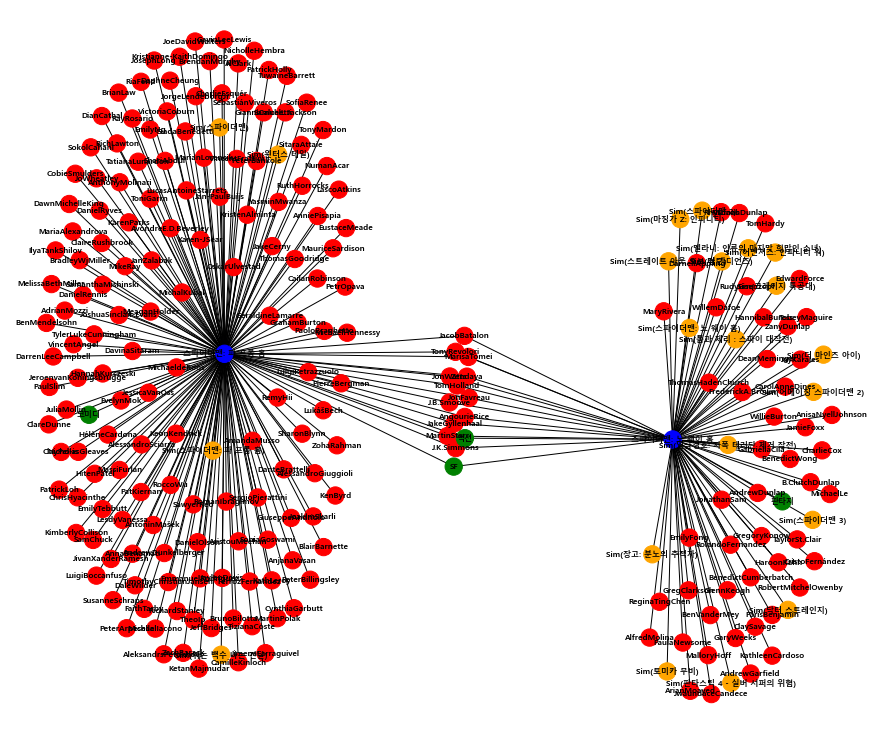

In [49]:
list_in=["스파이더맨: 파 프롬 홈","스파이더맨: 노 웨이 홈"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [24]:
result = get_recommendation("스파이더맨: 홈커밍")
print("*"*40+"\n Recommendation for '스파이더맨: 홈커밍'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '스파이더맨: 홈커밍'
****************************************
어벤져스: 인피니티 워     6.263091
스파이더맨: 파 프롬 홈    6.104876
스파이더맨: 노 웨이 홈    4.899829
캡틴 아메리카: 시빌 워    4.146309
어벤져스: 엔드게임       3.781588
dtype: float64


In [22]:
result = get_recommendation("화양연화")
print("*"*40+"\n Recommendation for '화양연화'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '화양연화'
****************************************
2046      1.963559
아비정전      1.863546
일대종사      1.669545
천하무쌍      1.412775
트루 시크릿    1.355216
dtype: float64


In [25]:
result = get_recommendation("부산행")
print("*"*40+"\n Recommendation for '부산행'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '부산행'
****************************************
82년생 김지영    2.477377
염력          2.100296
서울역         1.950637
궁합          1.628786
반도          1.411314
dtype: float64


In [26]:
result = get_recommendation("반도")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
승리호     2.525768
염력      2.476621
백두산     2.113494
배심원들    1.841933
기생충     1.677535
dtype: float64


In [27]:
result = get_recommendation("쇼생크 탈출")
print("*"*40+"\n Recommendation for '쇼생크 탈출'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '쇼생크 탈출'
****************************************
그린 마일     3.948676
미스트       2.263093
로보캅       1.951033
서든 데쓰     1.774462
스마트 피플    1.555029
dtype: float64


In [28]:
result = get_recommendation("포레스트 검프")
print("*"*40+"\n Recommendation for '포레스트 검프'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '포레스트 검프'
****************************************
사선에서               2.465268
패트리어트 - 늪 속의 여우    2.176364
콘택트                2.033779
JFK                1.932812
대역전                1.922542
dtype: float64


In [30]:
result = get_recommendation("원스 어폰 어 타임 인… 할리우드")
print("*"*40+"\n Recommendation for '원스 어폰 어 타임 인… 할리우드'\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for '원스 어폰 어 타임 인… 할리우드'
****************************************
장고: 분노의 추적자     5.357973
헤이트풀8           4.053991
쿠엔틴 타란티노 8      2.773514
바스터즈: 거친 녀석들    2.462068
데드우드: 더 무비      2.459116
dtype: float64


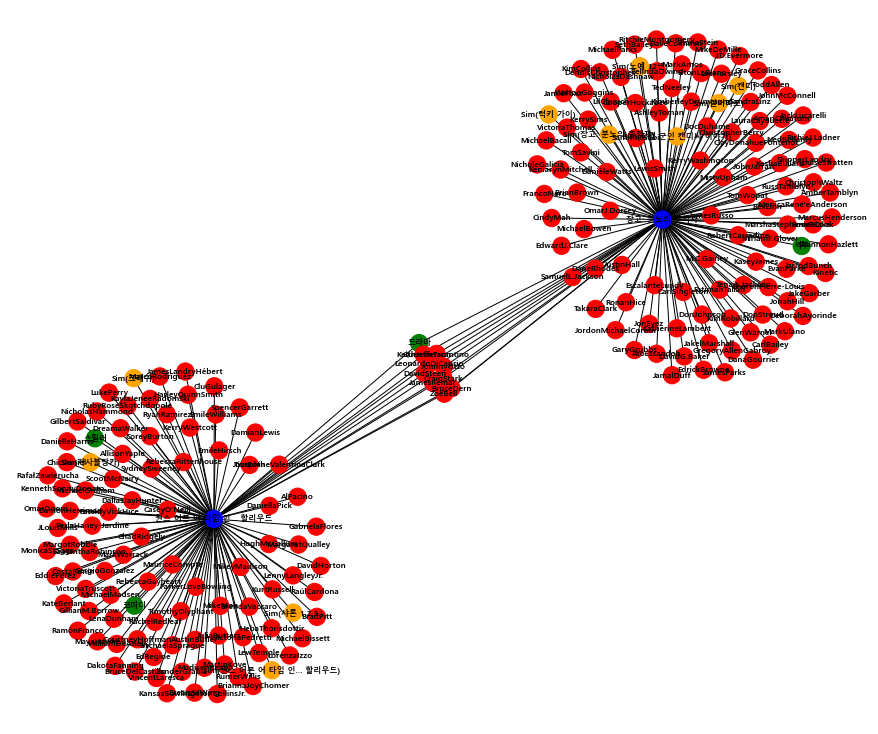

In [43]:
list_in=["원스 어폰 어 타임 인… 할리우드","장고: 분노의 추적자"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

C:\Users\jlune\.conda\envs\vv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jlune\.conda\envs\vv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jlune\.conda\envs\vv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 363 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jlune\.conda\envs\vv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 333 missing from current font.
  font.set_text(s, 0, flags=flags)


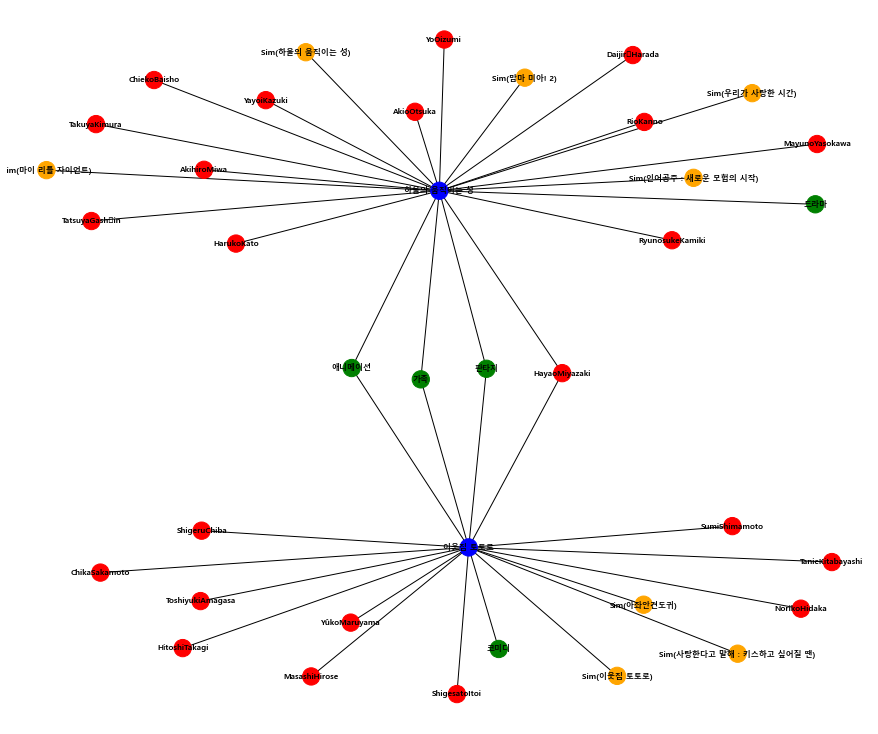

In [44]:
list_in=["하울의 움직이는 성","이웃집 토토로"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [51]:
result = get_recommendation("스파이더맨: 파 프롬 홈")
print("*"*40+"\n Recommendation for '스파이더맨: 파 프롬 홈'\n"+"*"*40)
print(result.head())
result1 = get_recommendation("화양연화")
print("*"*40+"\n Recommendation for '화양연화'\n"+"*"*40)
print(result1.head())
result2 = get_recommendation("부산행")
print("*"*40+"\n Recommendation for '부산행'\n"+"*"*40)
print(result2.head())

****************************************
 Recommendation for '스파이더맨: 파 프롬 홈'
****************************************
스파이더맨: 홈커밍        6.104876
분노의 질주: 홉스 & 쇼    5.478773
스파이더맨: 노 웨이 홈     5.135513
아르테미스 파울          4.841783
한 솔로: 스타워즈 스토리    4.722141
dtype: float64
****************************************
 Recommendation for '화양연화'
****************************************
2046      1.963559
아비정전      1.863546
일대종사      1.669545
천하무쌍      1.412775
트루 시크릿    1.355216
dtype: float64
****************************************
 Recommendation for '부산행'
****************************************
82년생 김지영    2.477377
염력          2.100296
서울역         1.950637
궁합          1.628786
반도          1.411314
dtype: float64


In [52]:
result3 = get_recommendation("포레스트 검프")
print("*"*40+"\n Recommendation for '포레스트 검프'\n"+"*"*40)
print(result3.head())
result4 = get_recommendation("원스 어폰 어 타임 인… 할리우드")
print("*"*40+"\n Recommendation for '원스 어폰 어 타임 인… 할리우드'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for '포레스트 검프'
****************************************
사선에서               2.465268
패트리어트 - 늪 속의 여우    2.176364
콘택트                2.033779
JFK                1.932812
대역전                1.922542
dtype: float64
****************************************
 Recommendation for '원스 어폰 어 타임 인… 할리우드'
****************************************
장고: 분노의 추적자     5.357973
헤이트풀8           4.053991
쿠엔틴 타란티노 8      2.773514
바스터즈: 거친 녀석들    2.462068
데드우드: 더 무비      2.459116
dtype: float64
